In [1]:
import utilities
import Environment
import Shop
from mab.ts_learner import *
from mab.ucb_learner import *

In [2]:

#we know: number of customers per class, price of second item, conversion rate of second item
#environment setting
shop_ts = Shop.Shop()
shop_ucb = Shop.Shop()
shop_clairvoyant = Shop.Shop()

env = Environment.Environment(shop_clairvoyant.prices1,shop_clairvoyant.prices2,shop_clairvoyant.discounts)

shop_clairvoyant.set_conv_rate(env.true_conv1, env.true_conv2)
shop_ts.set_conv_rate(env.true_conv1,env.true_conv2)
shop_ucb.set_conv_rate(env.true_conv1, env.true_conv2)


In [3]:
days = 365

arms = env.prices1
ts_learner =TS_Learner(arms=arms)      
u_learner = UCB(n_arms=len(arms))

ts_rewards_per_class_per_day = []
u_rewards_per_class_per_day = []
clairvoyant_per_class_per_day = []

for day in range(days):
    #generating customers

    env.generate_next_day_customers()
    
    shop_clairvoyant.set_expected_customers(env.customers)
    shop_ts.set_expected_customers(env.customers)
    shop_ucb.set_expected_customers(env.customers)


    chosen_price1 = ts_learner.pull_arm(shop_ts.customers)[0]
    chosen_price2 = u_learner.pull_arm() 
    #for each day, we choose a different candidate price1 and then use it to calculate the promos of price2

    shop_clairvoyant.best_promo_per_class()
    shop_ts.best_promo_per_class(chosen_price1)
    shop_ucb.best_promo_per_class(chosen_price2)
    
    shop_clairvoyant.print_coupons()
    shop_ts.print_coupons()
    shop_ucb.print_coupons()
    
    clairvoyant_per_class = []
    revenue_ts = []
    revenue_ucb = []
    
    np.random.shuffle(shop_ts.customers_random)

    for cust in shop_ts.customers_random:
        partial_revenue = 0
        cust = (int)(cust)

        has_bought1 = env.round1(cust, shop_ts.best_price[0])
        ts_learner.update(chosen_price1, has_bought1, cust)

        has_bought1b = env.round1(cust, shop_ucb.best_price[0])
        u_learner.update(chosen_price2, has_bought1b,cust)
        
        partial_revenue_ts = has_bought1*shop_ts.best_price[0]
        partial_revenue_ucb = has_bought1b*shop_ucb.best_price[0]


        if has_bought1 == 1:
            has_bought2 = env.round2(cust, shop_ts.matched_promos[cust], shop_ts.best_price[1])
            partial_revenue_ts += has_bought2*shop_ts.best_price[1]*(1-shop_ts.discounts[shop_ts.matched_promos[cust]])
        revenue_ts.append(partial_revenue_ts)
        
        if has_bought1b == 1:
            has_bought2 = env.round2(cust, shop_ucb.matched_promos[cust], shop_ucb.best_price[1])
            partial_revenue_ucb += has_bought2*shop_ucb.best_price[1]*(1-shop_ucb.discounts[shop_ucb.matched_promos[cust]])
        revenue_ucb.append(partial_revenue_ucb)
        expected_revenue = shop_clairvoyant.best_price[0]*env.true_conv1[cust, utilities.index(env.prices1, shop_clairvoyant.best_price[0])] + env.true_conv1[cust, utilities.index(env.prices1, shop_clairvoyant.best_price[0])]*env.true_conv2[cust, shop_clairvoyant.matched_promos[cust], utilities.index(env.prices1, shop_clairvoyant.best_price[0])]*shop_clairvoyant.best_price[1]*(1-shop_clairvoyant.discounts[shop_clairvoyant.matched_promos[cust]])
        clairvoyant_per_class.append(expected_revenue)
    
    ts_rewards_per_class_per_day.append(np.mean(revenue_ts))
    u_rewards_per_class_per_day.append(np.mean(revenue_ucb))
    clairvoyant_per_class_per_day.append(np.mean(clairvoyant_per_class))


In [4]:
print(ts_learner.pull_arm(env.customers))
print(shop_clairvoyant.best_price)
print(shop_clairvoyant.prices1)

(2,)
(360.0, 700.0)
[ 80. 200. 360. 560. 800.]


Text(0, 0.5, 'Revenue')

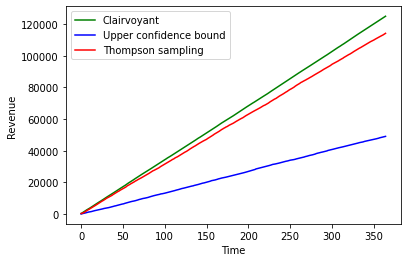

In [7]:
import matplotlib.pyplot as plt

plt.plot(np.cumsum(clairvoyant_per_class_per_day), color='green', label='Clairvoyant')
plt.plot(np.cumsum(u_rewards_per_class_per_day),color='blue',label='Upper confidence bound')
plt.plot(np.cumsum(ts_rewards_per_class_per_day),color='red',label = 'Thompson sampling')

plt.legend()
plt.xlabel('Time')
plt.ylabel('Revenue')

